# **Fine-tuning llama3 for question answering tasks using unsloth**
**This Notebook uses [unsloth](https://github.com/unslothai/unsloth) to fine-tune llama3-8b.**    
**It uses the dataset from the [LLM for Environmental Review](https://www.kaggle.com/competitions/llm-for-environmental-review) competition.**   
**This Notebook is modified from the following two notebooks [Alpaca + Llama-3 8b Unsloth 2x faster finetuning](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing) and [Kaggle Gemma2 9b Unsloth notebook](https://www.kaggle.com/code/danielhanchen/kaggle-gemma2-9b-unsloth-notebook).**

In [ ]:
%%capture
!mamba install --force-reinstall aiohttp -y
!pip install -U "xformers<0.0.26" --index-url https://download.pytorch.org/whl/cu121
!pip install "unsloth[kaggle-new] @ git+https://github.com/unslothai/unsloth.git"

# Temporary fix for https://github.com/huggingface/datasets/issues/6753
!pip install datasets==2.16.0 fsspec==2023.10.0 gcsfs==2023.10.0

import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

**It should be noted that the description of the competition dataset shows that there are ten types of questions with "open" but no "problem-solving", but in the training set and test set, there is no "open" problem_type but there is "problem-solving"**

In [ ]:
def get_instruction(question_type):
    instructions = {
        'closed': "Just answer with Yes or No.",
        'evaluation': "Assess the situation critically. Provide a concise evaluation in 1-2 sentences.",
        'process': "Outline the steps briefly. Use no more than three sentences to describe the process.",
        'recall': "State the fact or information directly. Keep your answer to one sentence.",
        'convergent': "Provide a focused, precise answer. Use 1-2 sentences maximum.",
        'funnel': "Start broad, then narrow down to specifics. Use up to three sentences.",
        'comparison': "Highlight key similarities and differences concisely. Use 2-3 sentences maximum.",
        'divergent': "Explore multiple possibilities briefly. Limit your response to three sentences.",
        'inference': "Draw a logical conclusion based on the information. Use 1-2 sentences for your inference.",
        'problem-solving': "Propose solutions to problems. Use 1-2 sentences for your process. "
    }
    return instructions.get(question_type)


prompt = """Respond to the following question based on the provided instruction and context. Ensure your answer is accurate, relevant, and adheres to the specified format.
### Instruction:
{}

### Question:
{}

### Context:
{}

### Response:
{}"""

In [ ]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = [get_instruction(qt) for qt in examples["question_type"]]
    question     = examples['question']
    contexts     = examples["context"]
    outputs      = examples["groundtruth_answer"]
    texts = []
    for instruction, question, context, output in zip(instructions, question, contexts, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, question, context, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("csv", data_files="/kaggle/input/llm-for-environmental-review/NEPAQuAD1_train.csv", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

In [ ]:
trainer_stats = trainer.train()

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt.format(
        "Just answer with Yes or No.", # instruction
        "Is the integrated disposal facility referred to as IDF-West in the ROD?", # question
        "In December 2012, the U.S. Department of Energy (DOE) issued the Tank Closure and WasteManagement Environmental Impact Statement for the Hanford Site, Richland, Washington(DOE/EIS-0391; DOE 2012) (hereinafter, TC&WM EIS). In the TC&WM EIS, DOE analyzed17 alternatives,1 11 of which involved retrieval, treatment, storage, and disposal of tank wastes, followed by the closure of the single-shell waste storage tanks (SST) at the Hanford Site. DOEissued the first in a series of Records of Decision (RODs) for the Final TC&WM EIS on December13, 2013 (Volume 78 of the Federal Register, page 75913 [78 FR 75913]).22 For the tankclosure portion of the alternatives, which encompasses operations of the tank farm and WasteTreatment and Immobilization Plant (WTP), DOE announced that it would select Tank ClosureAlternative 2B,3 which would, among other things: (1) retrieve 99 percent of the waste from theSSTs; (2) treat tank waste, including pretreatment of tank waste with separation into low-activitywaste (LAW) and high-level radioactive waste (HLW); and (3) dispose of the vitrified LAW andsecondary waste4 and construct immobilized HLW (IHLW) interim storage modules to store theIHLW prior to disposal.5 The 2013 ROD also stated, ""Tank waste treatment includespretreatment of all tank waste, with separation into LAW and HLW. New evaporation capacity,upgrades to the Effluent Treatment Facility (ETF), new transfer lines, and processing of bothvitrified LAW and secondary waste for disposal are part of tank waste treatment."" For wastemanagement, the ROD further stated: ""DOE has decided to implement Waste ManagementAlternative 2, which includes disposal of LLW [low-level radioactive waste] and MLLW [mixedlow-level radioactive waste] at IDF [Integrated Disposal Facility]-East from tank treatmentoperations.", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

**The following code can save the model locally or upload it to HuggingFace Hub.**

In [ ]:
# model.save_pretrained("model_name") # Local saving
# tokenizer.save_pretrained("model_name")

# model.push_to_hub("your_name/model_name", token = "hf_xxxx") # Online saving
# tokenizer.push_to_hub("your_name/model_name", token = "hf_xxxx") # Online saving

In [ ]:
import re
import csv
# Process the CSV file and write results to a new CSV
def process_csv(input_file_path, output_file_path):
    with open(input_file_path, 'r', encoding='utf-8-sig') as input_csvfile, open(output_file_path, 'w', newline='', encoding='utf-8') as output_csvfile:
        reader = csv.DictReader(input_csvfile)
        writer = csv.writer(output_csvfile)

        # Write header to output CSV
        writer.writerow(['ID', 'PREDICTED_ANSWER'])

        for row in reader:
            id = row['ID']
            question_type = row['question_type']
            question = row['question']
            context = row['context']
            instruction = get_instruction(question_type)

            prompt = prompt_predict.format(instruction=instruction, question=question, context=context)

            inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
            outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
            full_output = tokenizer.batch_decode(outputs)[0]
            
            match = re.search(r'### Response:\n(.*)', full_output, re.DOTALL)
            result = re.sub(r'<\|end_of_text\|>', '', match.group(1))
            
            print(result)
            print("=" * 20)

            # Write to output CSV
            writer.writerow([id, result])


# Run the process
input_csv_file_path = "/kaggle/input/llm-for-environmental-review/NEPAQuAD1_test.csv"  # Replace with the actual path to your input CSV file
output_csv_file_path = "nepaquad1-test-submit-<lhai0704>.csv"  # Replace with the desired path for your output CSV file
process_csv(input_csv_file_path, output_csv_file_path)

print(f"Processing complete. Results saved to {output_csv_file_path}")


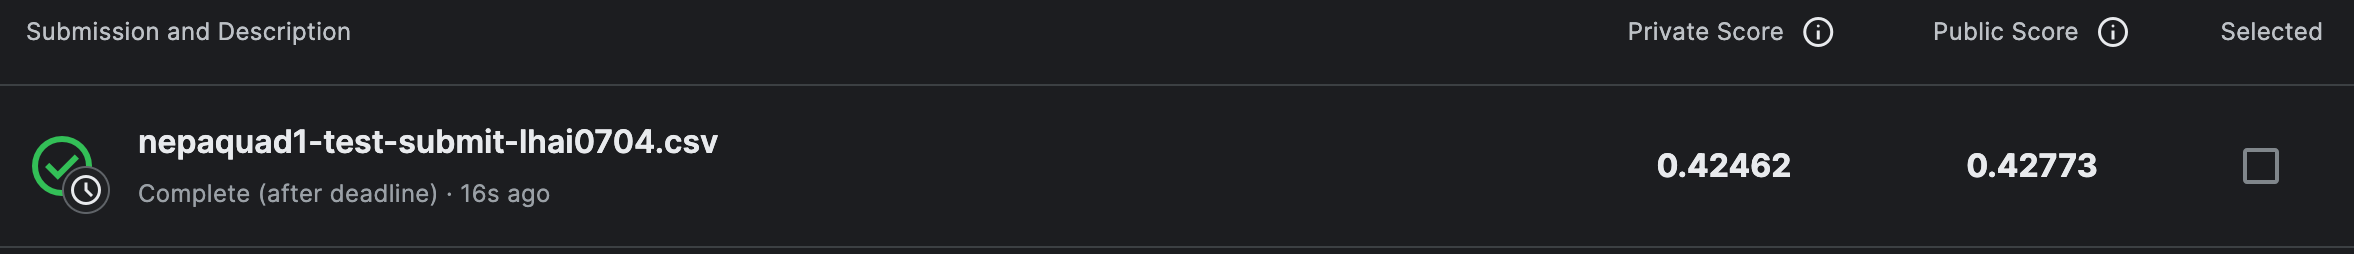
**Possible improvements:**

1. Use RAG and other technologies to generate more training data for fine-tuning.

2. Improve prompt to optimize the content generated by the model